<a href="https://colab.research.google.com/github/PhilippMatthes/diplom/blob/master/src/shl-deep-learning-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a deep CNN to directly classify SHL timeseries data

The following notebook contains code to classify SHL timeseries data with deep convolutional neural networks. Steps:

- Data preprocessing
- Metamodel definition
- Hyperband gridsearch
- Model conversion and optimization

# General setup steps

### Free up disk space

In [1]:
!rm -rf /usr/local/lib/python2.7
!rm -rf /swift
!rm -rf /usr/local/lib/python3.6/dist-packages/torch
!rm -rf /usr/local/lib/python3.6/dist-packages/pystan
!rm -rf /usr/local/lib/python3.6/dist-packages/spacy
!rm -rf /tensorflow-1.15.2/

### Get our base repo so that we can use predefined architectures and pretrained scalers

In [2]:
!git clone https://github.com/philippmatthes/diplom

Cloning into 'diplom'...
remote: Enumerating objects: 2661, done.
remote: Counting objects: 100% (1998/1998), done.
remote: Compressing objects: 100% (1364/1364), done.
remote: Total 2661 (delta 1060), reused 1372 (delta 530), pack-reused 663
Receiving objects: 100% (2661/2661), 63.12 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (1436/1436), done.


### Switch to our src dir for further processing.

In [3]:
%cd /content/diplom/src

/content/diplom/src


### Create the dataset dir in which our dataset will be downloaded next

In [4]:
!mkdir shl-dataset

### Download the SHL dataset from the shl server

This might take some time, on Google Colab its approx. 45 minutes. You can also mount your Google Drive if you have enough space available

In [ ]:
!wget -nc -O shl-dataset/challenge-2019-user1_torso.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_torso.zip
!wget -nc -O shl-dataset/challenge-2019-user1_bag.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_bag.zip
!wget -nc -O shl-dataset/challenge-2019-user1_hips.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_hips.zip
!wget -nc -O shl-dataset/challenge-2020-user1_hand.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2020/challenge-2020-train_hand.zip
!wget -nc -O shl-dataset/challenge-2020-users23_torso_bag_hips_hand.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2020/challenge-2020-validation.zip

### Unzip training datasets

Next we unzip our dataset into the running instance's filestorage. *Note that this will probably not work for free subscriptions of Google Colab, since the data is approximately 90-100 GB when extracted.*

In [ ]:
!unzip -n -d shl-dataset/challenge-2019-user1_torso shl-dataset/challenge-2019-user1_torso.zip
!rm shl-dataset/challenge-2019-user1_torso.zip
!unzip -n -d shl-dataset/challenge-2019-user1_bag shl-dataset/challenge-2019-user1_bag.zip
!rm shl-dataset/challenge-2019-user1_bag.zip
!unzip -n -d shl-dataset/challenge-2019-user1_hips shl-dataset/challenge-2019-user1_hips.zip
!rm shl-dataset/challenge-2019-user1_hips.zip
!unzip -n -d shl-dataset/challenge-2020-user1_hand shl-dataset/challenge-2020-user1_hand.zip
!rm shl-dataset/challenge-2020-user1_hand.zip
!unzip -n -d shl-dataset/challenge-2020-users23_torso_bag_hips_hand shl-dataset/challenge-2020-users23_torso_bag_hips_hand.zip
!rm shl-dataset/challenge-2020-users23_torso_bag_hips_hand.zip

### Mount Google Drive for progress logging

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Copy most recent gridsearch savestate

In [ ]:
datestr = '2021-08-29'

!mkdir /content/diplom/src/logs/
!unzip -n -d /content/diplom/src/logs/shl-gridsearch/ /content/drive/MyDrive/logs-{datestr}.zip
!unzip -n -d /content/diplom/src/models/shl-gridsearch/ /content/drive/MyDrive/gridsearch-{datestr}.zip

### Check the CUDA version

In [9]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


### Change into our src dir and select TF 2.0

In [10]:
%cd /content/diplom/src
%tensorflow_version 2.x

/content/diplom/src


### Check configuration and hardware resources

In [11]:
import distutils

import tensorflow as tf

print(f'Using TensorFlow: {tf.__version__}')

if distutils.version.LooseVersion(tf.__version__) < '2.0':
    raise Exception('This notebook is compatible with TensorFlow 2.0 or higher.')

print('GPU Devices:')
tf.config.list_physical_devices('GPU')

Using TensorFlow: 2.6.0
GPU Devices:


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset preprocessing

### Define all datasets to train our model on

In [12]:
from pathlib import Path

TRAIN_DATASET_DIRS = [
    Path('shl-dataset/challenge-2019-user1_torso/train/Torso'),
    Path('shl-dataset/challenge-2019-user1_bag/train/Bag'),
    Path('shl-dataset/challenge-2019-user1_hips/train/Hips'),
    Path('shl-dataset/challenge-2020-user1_hand/train/Hand'),
    Path('shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Torso'),         
    Path('shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Bag'),   
    Path('shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hips'),   
    Path('shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hand'),   
]

### Define more useful constants about our dataset

In [13]:
LABEL_ORDER = [
    'Null',
    'Still',
    'Walking',
    'Run',
    'Bike',
    'Car',
    'Bus',
    'Train',
    'Subway',
]

SAMPLE_LENGTH = 500

### Include weighting results from data analysis

In [14]:
CLASS_WEIGHTS = {
    0: 0.0, # NULL label
    1: 1.0021671573438011, 
    2: 0.9985739895697523, 
    3: 2.8994439843842423, 
    4: 1.044135815617944, 
    5: 0.7723505499007343, 
    6: 0.8652474758172704, 
    7: 0.7842127155793044, 
    8: 1.0283208861290594
}

### Define features for our dataset

In [15]:
from collections import OrderedDict

import numpy as np

# Attributes to load from our dataset
X_attributes = [
    'acc_x', 'acc_y', 'acc_z',
    'mag_x', 'mag_y', 'mag_z',
    'gyr_x', 'gyr_y', 'gyr_z',
    # Parts that are not needed:
    # 'gra_x', 'gra_y', 'gra_z',
    # 'lacc_x', 'lacc_y', 'lacc_z',
    # 'ori_x', 'ori_y', 'ori_z', 'ori_w',
]

# Files within the dataset that contain our attributes
X_files = [
    'Acc_x.txt', 'Acc_y.txt', 'Acc_z.txt',
    'Mag_x.txt', 'Mag_y.txt', 'Mag_z.txt',
    'Gyr_x.txt', 'Gyr_y.txt', 'Gyr_z.txt',
    # Parts that are not needed:
    # 'Gra_x.txt', 'Gra_y.txt', 'Gra_z.txt',
    # 'LAcc_x.txt', 'LAcc_y.txt', 'LAcc_z.txt',
    # 'Ori_x.txt', 'Ori_y.txt', 'Ori_z.txt', 'Ori_w.txt',
]

# Features to generate from our loaded attributes
# Note that `a` is going to be a dict of attribute tracks
X_features = OrderedDict({
    'acc_mag': lambda a: np.sqrt(a['acc_x']**2 + a['acc_y']**2 + a['acc_z']**2),
    'mag_mag': lambda a: np.sqrt(a['mag_x']**2 + a['mag_y']**2 + a['mag_z']**2),
    'gyr_mag': lambda a: np.sqrt(a['gyr_x']**2 + a['gyr_y']**2 + a['gyr_z']**2),
})

# Define where to find our labels for supervised learning
y_file = 'Label.txt'
y_attribute = 'labels'

### Load pretrained power transformers for feature scaling

In [16]:
import joblib

X_feature_scalers = OrderedDict({})
for feature_name, _ in X_features.items():
    scaler_dir = f'models/shl-scalers/{feature_name}.scaler.joblib'
    scaler = joblib.load(scaler_dir)
    scaler.copy = False # Save memory
    X_feature_scalers[feature_name] = scaler
    print(f'Loaded scaler from {scaler_dir}.')

Loaded scaler from models/shl-scalers/acc_mag.scaler.joblib.
Loaded scaler from models/shl-scalers/mag_mag.scaler.joblib.
Loaded scaler from models/shl-scalers/gyr_mag.scaler.joblib.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PowerTransformer from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Export our scalers to mobile for later use

In [17]:
import json

for feature_name, scaler in X_feature_scalers.items():
    with open(f'models/shl-scalers/{feature_name}.scaler.json', 'w') as f:
        f.write(json.dumps({
            'lambdas': scaler.lambdas_.tolist(),
            'means': scaler._scaler.mean_.tolist(),
            'scales': scaler._scaler.scale_.tolist(),
        }))

### Load the training and validation data into a high performance datatype

In [18]:
import os
import shutil

from typing import Generator, List, Tuple

from tqdm import tqdm

import pandas as pd

def read_chunks(
    n_chunks: int, 
    X_attr_readers: List[pd.io.parsers.TextFileReader], 
    y_attr_reader: pd.io.parsers.TextFileReader
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    """
    Read chunks of attribute data and yield it to the caller as tuples of X, y.
    
    This function returns a generator which can be iterated.
    """
    for _ in range(n_chunks):
        # Load raw attribute tracks
        X_raw_attrs = OrderedDict({})
        for X_attribute, X_attr_reader in zip(X_attributes, X_attr_readers):
            X_attr_track = next(X_attr_reader)
            X_attr_track = np.nan_to_num(X_attr_track.to_numpy())
            X_raw_attrs[X_attribute] = X_attr_track

        # Calculate features
        X_feature_tracks = None
        for X_feature_name, X_feature_func in X_features.items():
            X_feature_track = X_feature_func(X_raw_attrs)
            X_feature_track = X_feature_scalers[X_feature_name] \
                .transform(X_feature_track)
            if X_feature_tracks is None:
                X_feature_tracks = X_feature_track
            else:
                X_feature_tracks = np.dstack((X_feature_tracks, X_feature_track))

        # Load labels
        y_attr_track = next(y_attr_reader) # dim (None, sample_length)
        y_attr_track = np.nan_to_num(y_attr_track.to_numpy()) # dim (None, sample_length)
        y_attr_track = y_attr_track[:, 0] # dim (None, 1)

        yield X_feature_tracks, y_attr_track

def count_samples(dataset_dir: Path) -> int:
    """Count the total amount of samples in a shl dataset."""
    n_samples = 0
    # Every file in the dataset has the same length, use the labels file
    with open(dataset_dir / y_file) as f:
        for _ in tqdm(f, desc=f'Counting samples in {dataset_dir}'):
            n_samples += 1
    return n_samples

def create_chunked_readers(
    dataset_dir: Path,
    chunksize: int, 
    xdtype=np.float32, # Use np.float16 with caution, can lead to overflows
    ydtype=np.int
) -> Tuple[List[pd.io.parsers.TextFileReader], pd.io.parsers.TextFileReader]:
    """Initialize chunked csv readers and return them to the caller as a tuple."""
    read_csv_kwargs = { 'sep': ' ', 'header': None, 'chunksize': chunksize }

    X_attr_readers = [] # (dim datasets x readers)
    for filename in X_files:
        X_reader = pd.read_csv(dataset_dir / filename, dtype=xdtype, **read_csv_kwargs)
        X_attr_readers.append(X_reader)
    y_attr_reader = pd.read_csv(dataset_dir / y_file, dtype=ydtype, **read_csv_kwargs)

    return X_attr_readers, y_attr_reader

def export_tfrecords(
    dataset_dir: Path,
    n_chunks=16, # Load dataset in parts to not overload memory
):
    """Transform the given shl dataset into a memory efficient TFRecord."""
    target_dir = f'{dataset_dir}.tfrecord'
    if os.path.isfile(target_dir):
        print(f'{target_dir} already exists.')
        return

    print(f'Exporting to {target_dir}.')

    n_samples = count_samples(dataset_dir)
    chunksize = int(np.floor(n_samples / n_chunks))
    X_attr_readers, y_attr_reader = create_chunked_readers(dataset_dir, chunksize)    

    with tf.io.TFRecordWriter(str(target_dir)) as file_writer:
        with tqdm(total=n_samples, desc=f'Reading samples to {target_dir}') as pbar:
            for X_feature_tracks, y_attr_track in read_chunks(
                n_chunks, X_attr_readers, y_attr_reader
            ):
                for X, y in zip(X_feature_tracks, y_attr_track):
                    X_flat = X.flatten() # TFRecords don't support multidimensional arrays
                    record_bytes = tf.train.Example(features=tf.train.Features(feature={
                        'X': tf.train.Feature(float_list=tf.train.FloatList(value=X_flat)),
                        'y': tf.train.Feature(int64_list=tf.train.Int64List(value=[y])) 
                    })).SerializeToString()
                    file_writer.write(record_bytes)
                pbar.update(chunksize)

for dataset_dir in TRAIN_DATASET_DIRS:
    export_tfrecords(dataset_dir)

Exporting to shl-dataset/challenge-2019-user1_torso/train/Torso.tfrecord.


Counting samples in shl-dataset/challenge-2019-user1_torso/train/Torso: 196072it [00:02, 79872.57it/s]
Reading samples to shl-dataset/challenge-2019-user1_torso/train/Torso.tfrecord: 100%|█████████▉| 196064/196072 [04:16<00:00, 765.48it/s]


Exporting to shl-dataset/challenge-2019-user1_bag/train/Bag.tfrecord.


Counting samples in shl-dataset/challenge-2019-user1_bag/train/Bag: 196072it [00:02, 78120.65it/s]
Reading samples to shl-dataset/challenge-2019-user1_bag/train/Bag.tfrecord: 100%|█████████▉| 196064/196072 [04:21<00:00, 750.71it/s]


Exporting to shl-dataset/challenge-2019-user1_hips/train/Hips.tfrecord.


Counting samples in shl-dataset/challenge-2019-user1_hips/train/Hips: 196072it [00:02, 72459.82it/s]
Reading samples to shl-dataset/challenge-2019-user1_hips/train/Hips.tfrecord: 100%|█████████▉| 196064/196072 [04:26<00:00, 735.49it/s]


Exporting to shl-dataset/challenge-2020-user1_hand/train/Hand.tfrecord.


Counting samples in shl-dataset/challenge-2020-user1_hand/train/Hand: 196072it [00:02, 78010.81it/s]
Reading samples to shl-dataset/challenge-2020-user1_hand/train/Hand.tfrecord: 100%|█████████▉| 196064/196072 [04:28<00:00, 730.69it/s]


Exporting to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Torso.tfrecord.


Counting samples in shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Torso: 28789it [00:00, 90619.95it/s]
Reading samples to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Torso.tfrecord: 100%|█████████▉| 28784/28789 [00:43<00:00, 666.35it/s]


Exporting to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Bag.tfrecord.


Counting samples in shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Bag: 28789it [00:00, 89402.72it/s]
Reading samples to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Bag.tfrecord: 100%|█████████▉| 28784/28789 [00:43<00:00, 664.96it/s]


Exporting to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hips.tfrecord.


Counting samples in shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hips: 28789it [00:00, 90071.21it/s]
Reading samples to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hips.tfrecord: 100%|█████████▉| 28784/28789 [00:43<00:00, 665.97it/s]


Exporting to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hand.tfrecord.


Counting samples in shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hand: 28789it [00:00, 91641.19it/s]
Reading samples to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hand.tfrecord: 100%|█████████▉| 28784/28789 [00:43<00:00, 665.35it/s]


### Load the TFRecord files into iterable dataset proxies

In [19]:
def decode_tfrecord(record_bytes) -> Tuple[tf.Tensor, tf.Tensor]:
    """Decode a TFRecord example to X, y from its serialized representation."""
    example = tf.io.parse_single_example(record_bytes, {
        'X': tf.io.FixedLenFeature([SAMPLE_LENGTH, len(X_features)], tf.float32),
        'y': tf.io.FixedLenFeature([1], tf.int64)
    })
    return example['X'], example['y']

def create_train_validation_datasets(
    dataset_dirs: List[Path], 
    batch_size=64, # 128 can lead to GPU OOM crashes
    shuffle_size=0.1, # Part of the dataset to keep in memory while shuffling
    validation_size=0.05 # Part of the dataset to use for validation
) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    """
    Create interleaved, shuffled and batched train and 
    validation datasets from the dataset dirs.
    
    Note that this function reads previously generated TFRecords under 
    `dataset_dir.tfrecord` -> use `export_tfrecords` for that.
    """
    tfrecord_dirs = [f'{d}.tfrecord' for d in dataset_dirs]
    print(f'Creating train and validation dataset over {tfrecord_dirs}.')

    # Create a strategy to interleave the datasets
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_dirs)
    # Combine the partial datasets
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x), 
        cycle_length=batch_size, # Number of input elements that are processed concurrently
        block_length=1 # Return only one element at a time, batching is done later
    )
    sample_count = sum(1 for _ in dataset)
    print(f'Counted {sample_count} samples in combined dataset.')

    # Shuffle the dataset, but only once to avoid train-test-overlaps
    shuffle_shard_size = int(np.floor(sample_count * shuffle_size))
    dataset = dataset.shuffle(shuffle_shard_size, reshuffle_each_iteration=False)
    # Decode the dataset and distribute the calls across the available cpus
    dataset = dataset.map(decode_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    # Split the dataset into batches
    dataset = dataset.batch(batch_size)

    # Every 1 / validation_size batch becomes a validation batch
    validation_modulus = int(np.floor(1.0 / validation_size))

    validation_dataset = dataset.enumerate()
    validation_dataset = validation_dataset.filter(lambda i, batch: i % validation_modulus == 0)
    validation_dataset = validation_dataset.map(lambda i, batch: batch)
    print(f'Counted {sum(1 for _ in validation_dataset) * batch_size} samples in validation dataset.')

    train_dataset = dataset.enumerate()
    train_dataset = train_dataset.filter(lambda i, batch: i % validation_modulus != 0)
    train_dataset = train_dataset.map(lambda i, batch: batch)
    print(f'Counted {sum(1 for _ in train_dataset) * batch_size} samples in train dataset.')

    return train_dataset, validation_dataset

train_dataset, validation_dataset = create_train_validation_datasets(TRAIN_DATASET_DIRS)

Creating train and validation dataset over ['shl-dataset/challenge-2019-user1_torso/train/Torso.tfrecord', 'shl-dataset/challenge-2019-user1_bag/train/Bag.tfrecord', 'shl-dataset/challenge-2019-user1_hips/train/Hips.tfrecord', 'shl-dataset/challenge-2020-user1_hand/train/Hand.tfrecord', 'shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Torso.tfrecord', 'shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Bag.tfrecord', 'shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hips.tfrecord', 'shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hand.tfrecord'].
Counted 899392 samples in combined dataset.
Counted 44992 samples in validation dataset.
Counted 854400 samples in train dataset.


### Visualize the Data

This part is entirely optional and just to check if the data is somehow malformed to be sure no mistakes were made during preprocessing.

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(len(LABEL_ORDER), 3)
fig.set_size_inches(10, 30)

val_iter = iter(validation_dataset)
for i in range(16):
    X_batch, y_batch = next(val_iter)

    for X, y in zip(X_batch, y_batch):
        axs[y[0], 0].plot(X.numpy()[:, 0], color=(0, 0, 0, 0.1))
        axs[y[0], 1].plot(X.numpy()[:, 1], color=(0, 0, 0, 0.1))
        axs[y[0], 2].plot(X.numpy()[:, 2], color=(0, 0, 0, 0.1))

for i, label in enumerate(LABEL_ORDER):
    axs[i, 1].set_title(label)

plt.tight_layout()

# Model definition

### Install the gridsearch framework

In [20]:
import sys

!{sys.executable} -m pip install keras-tuner -q

     |████████████████████████████████| 97 kB 3.3 MB/s 


### Define a custom hyperband tuner

In [21]:
import os
import tempfile

from datetime import datetime

from keras_tuner import Hyperband
from keras_tuner.engine import hypermodel as hm_module
from keras_tuner.engine.logger import Logger

class Tuner(Hyperband):
    """
    A custom hyperband tuner.
    """
    def __init__(self, gridsearch_dir: Path, log_dir: Path, *init_args, **init_kwargs):
        self.gridsearch_dir = gridsearch_dir
        self.log_dir = log_dir
        super().__init__(*init_args, **init_kwargs)

    def run_trial(self, trial, *fit_args, **fit_kwargs):
        """
        Zip our progress and save to Google Drive every time a trial is run.
        """
        datestr = datetime.today().strftime('%Y-%m-%d')
        if os.path.isdir(self.gridsearch_dir):
            with tempfile.TemporaryDirectory() as tempdir:
                # Save gridsearch progress
                files_to_ignore = shutil.ignore_patterns('checkpoints*')
                shutil.copytree(self.gridsearch_dir, f'{tempdir}/gridsearch', ignore=files_to_ignore)
                shutil.make_archive(f'{tempdir}/gridsearch', 'zip', f'{tempdir}/gridsearch')
                shutil.copyfile(f'{tempdir}/gridsearch.zip', f'/content/drive/MyDrive/gridsearch-{datestr}.zip')
        if os.path.isdir(self.log_dir):
            with tempfile.TemporaryDirectory() as tempdir:
                # Save TensorFlow logs
                shutil.copytree(self.log_dir, f'{tempdir}/logs')
                shutil.make_archive(f'{tempdir}/logs', 'zip', f'{tempdir}/logs')
                shutil.copyfile(f'{tempdir}/logs.zip', f'/content/drive/MyDrive/logs-{datestr}.zip')
        super().run_trial(trial, *fit_args, **fit_kwargs)

### Load and import model definition packages

In [22]:
!{sys.executable} -m pip install kapre -q

In [23]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend
from tensorflow.keras import layers

from keras_tuner import HyperParameters, HyperModel

### Define generic helpers that will help us to take 2d and 1d ResNet inputs

In [28]:
INPUT_DIM_2D = 3 # (width, height, n_channels)
INPUT_DIM_1D = 2 # (n_timesteps, n_features)

def generic_zero_padding(input_dim: int, padding: int, *layer_args, **layer_kwargs) -> layers.Layer:
    if input_dim == INPUT_DIM_2D:
        padding_2d = ((padding, padding), (padding, padding))
        return layers.ZeroPadding2D(padding_2d, *layer_args, **layer_kwargs)
    elif input_dim == INPUT_DIM_1D:
        padding_1d = padding
        return layers.ZeroPadding1D(padding_1d, *layer_args, **layer_kwargs)
    else:
        raise ValueError(f'Unsupported zero padding dimension: {input_dim}')

def generic_batch_norm(input_dim: int, *layer_args, **layer_kwargs) -> layers.Layer:
    if input_dim == INPUT_DIM_2D:
        bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    elif input_dim == INPUT_DIM_1D:
        bn_axis = 2
    else:
        raise ValueError(f'Unsupported batchnorm dimension: {input_dim}')
    return layers.BatchNormalization(bn_axis, *layer_args, **layer_kwargs)

def _generic_layer(input_dim: int, dim_1d_proto, dim_2d_proto, *layer_args, **layer_kwargs) -> layers.Layer:
    if input_dim == INPUT_DIM_2D:
        return dim_2d_proto(*layer_args, **layer_kwargs)
    elif input_dim == INPUT_DIM_1D:
        return dim_1d_proto(*layer_args, **layer_kwargs)
    else:
        raise ValueError(f'Unsupported dimension: {input_dim}')

def generic_conv(input_dim: int, separable=False, *layer_args, **layer_kwargs) -> layers.Layer:
    if separable:
        return _generic_layer(input_dim, layers.SeparableConv1D, layers.SeparableConv2D, *layer_args, **layer_kwargs)
    return _generic_layer(input_dim, layers.Conv1D, layers.Conv2D, *layer_args, **layer_kwargs)

def generic_max_pool(input_dim: int, *layer_args, **layer_kwargs) -> layers.Layer:
    return _generic_layer(input_dim, layers.MaxPooling1D, layers.MaxPooling2D, *layer_args, **layer_kwargs)

def generic_global_avg_pool(input_dim: int, *layer_args, **layer_kwargs) -> layers.Layer:
    return _generic_layer(input_dim, layers.GlobalAveragePooling1D, layers.GlobalAveragePooling2D, *layer_args, **layer_kwargs)

def generic_global_max_pool(input_dim: int, *layer_args, **layer_kwargs) -> layers.Layer:
    return _generic_layer(input_dim, layers.GlobalMaxPooling1D, layers.GlobalMaxPooling2D, *layer_args, **layer_kwargs)

### Define ResNetV1 blocks and stacks
See https://arxiv.org/abs/1512.03385

In [35]:
def block1(input_dim, x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None, separable=False):
    """
    A ResNetV1 residual block.

    The code of this function is partially based on https://github.com/keras-team/keras-tuner
    which is licensed under Apache License 2.0, see https://www.apache.org/licenses/LICENSE-2.0
    """
    if conv_shortcut is True:
        shortcut = generic_conv(input_dim, separable, 4 * filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = generic_batch_norm(input_dim, epsilon=1.001e-5, name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = generic_conv(input_dim, separable, filters, 1, strides=stride, name=name + '_1_conv')(x)
    x = generic_batch_norm(input_dim, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = generic_conv(input_dim, separable, filters, kernel_size, padding='same', name=name + '_2_conv')(x)
    x = generic_batch_norm(input_dim, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = generic_conv(input_dim, separable, 4 * filters, 1, name=name + '_3_conv')(x)
    x = generic_batch_norm(input_dim, epsilon=1.001e-5, name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack1(input_dim, x, filters, blocks, stride1=2, name=None, separable=False):
    """
    A set of stacked ResNetV1 blocks.

    The code of this function is partially based on https://github.com/keras-team/keras-tuner
    which is licensed under Apache License 2.0, see https://www.apache.org/licenses/LICENSE-2.0
    """
    x = block1(input_dim, x, filters, stride=stride1, name=name + '_block1', separable=separable)
    for i in range(2, blocks + 1):
        x = block1(input_dim, x, filters, conv_shortcut=False, name=name + '_block' + str(i), separable=separable)
    return x

### Define ResNetV2 blocks and stacks

See https://arxiv.org/abs/1603.05027

In [36]:
def block2(input_dim, x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None, separable=False):
    """
    A residual block.

    The code of this function is partially based on https://github.com/keras-team/keras-tuner
    which is licensed under Apache License 2.0, see https://www.apache.org/licenses/LICENSE-2.0
    """
    preact = generic_batch_norm(input_dim, epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = generic_conv(input_dim, separable, 4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = generic_max_pool(input_dim, 1, strides=stride)(x) if stride > 1 else x

    x = generic_conv(input_dim, separable, filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = generic_batch_norm(input_dim, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = generic_zero_padding(input_dim, padding=1, name=name + '_2_pad')(x)
    x = generic_conv(input_dim, separable, filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = generic_batch_norm(input_dim, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = generic_conv(input_dim, separable, 4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x


def stack2(input_dim, x, filters, blocks, stride1=2, name=None, separable=False):
    """
    A set of stacked residual blocks.

    The code of this function is partially based on https://github.com/keras-team/keras-tuner
    which is licensed under Apache License 2.0, see https://www.apache.org/licenses/LICENSE-2.0
    """
    x = block2(input_dim, x, filters, conv_shortcut=True, name=name + '_block1', separable=separable)
    for i in range(2, blocks):
        x = block2(input_dim, x, filters, name=name + '_block' + str(i), separable=separable)
    x = block2(input_dim, x, filters, stride=stride1, name=name + '_block' + str(blocks), separable=separable)
    return x

### Create a combined hypermodel

In [37]:
class HyperResNet(HyperModel):
    """
    A ResNet hypermodel.

    The code of this class is partially based on https://github.com/keras-team/keras-tuner
    which is licensed under Apache License 2.0, see https://www.apache.org/licenses/LICENSE-2.0
    """

    def __init__(
        self,
        separable=False,
        include_top=True,
        input_shape=None,
        input_tensor=None,
        classes=None,
        **kwargs
    ):
        super().__init__(**kwargs)
        if include_top and classes is None:
            raise ValueError('You must specify `classes` when ' '`include_top=True`')

        if input_shape is None and input_tensor is None:
            raise ValueError(
                'You must specify either `input_shape` ' 'or `input_tensor`.'
            )

        self.separable = separable
        self.include_top = include_top
        self.input_shape = input_shape
        self.input_tensor = input_tensor
        self.classes = classes
    
    def _get_input(self):
        if self.input_tensor is not None:
            inputs = tf.keras.utils.get_source_inputs(self.input_tensor)
            input_dim = len(self.input_tensor.get_shape())
            x = self.input_tensor
        else:
            inputs = layers.Input(shape=self.input_shape)
            input_dim = len(self.input_shape)
            x = inputs
        return inputs, input_dim, x

    def build(self, hp):
        version = hp.Choice('version', ['ResNetV1', 'ResNetV2'], default='ResNetV2')
        conv3_depth = hp.Choice('conv3_depth', [4, 8])
        conv4_depth = hp.Choice('conv4_depth', [6, 23, 36])
        n_stacks = hp.Int('n_stacks', min_value=1, max_value=4, step=1)

        # Version-conditional fixed parameters
        preact = True if version == 'v2' else False
        use_bias = False if version == 'next' else True

        # Model definition.
        bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

        inputs, input_dim, x = self._get_input()

        # Initial conv2d block.
        x = generic_zero_padding(input_dim, padding=3, name='conv1_pad')(x)
        x = generic_conv(input_dim, self.separable, 64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)

        if preact is False:
            x = generic_batch_norm(input_dim, epsilon=1.001e-5, name='conv1_bn')(x)
            x = layers.Activation('relu', name='conv1_relu')(x)
        x = generic_zero_padding(input_dim, padding=1, name='pool1_pad')(x)
        x = generic_max_pool(input_dim, 3, strides=2, name='pool1_pool')(x)

        # Middle hypertunable stack.
        if version == 'ResNetV1':
            x = stack1(input_dim, x, 64, 3, stride1=1, name='conv2', separable=self.separable)
            if n_stacks > 1:
                x = stack1(input_dim, x, 128, conv3_depth, name='conv3', separable=self.separable)
            if n_stacks > 2:
                x = stack1(input_dim, x, 256, conv4_depth, name='conv4', separable=self.separable)
            if n_stacks > 3:
                x = stack1(input_dim, x, 512, 3, name='conv5', separable=self.separable)
        elif version == 'ResNetV2':
            x = stack2(input_dim, x, 64, 3, name='conv2', separable=self.separable)
            if n_stacks > 1:
                x = stack2(input_dim, x, 128, conv3_depth, name='conv3', separable=self.separable)
            if n_stacks > 2:
                x = stack2(input_dim, x, 256, conv4_depth, name='conv4', separable=self.separable)
            if n_stacks > 3:
                x = stack2(input_dim, x, 512, 3, stride1=1, name='conv5', separable=self.separable)

        # Top of the model.
        if preact is True:
            x = generic_batch_norm(input_dim, epsilon=1.001e-5, name='post_bn')(x)
            x = layers.Activation('relu', name='post_relu')(x)

        pooling = hp.Choice('pooling', ['avg', 'max'], default='avg')
        if pooling == 'avg':
            x = generic_global_avg_pool(input_dim, name='avg_pool')(x)
        elif pooling == 'max':
            x = generic_global_max_pool(input_dim, name='max_pool')(x)

        if self.include_top:
            x = layers.Dense(self.classes, activation='softmax', name='probs')(x)
            model = keras.Model(inputs, x, name=version)
            optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'], default='adam')
            optimizer = keras.optimizers.get(optimizer_name)
            optimizer.learning_rate = hp.Choice('learning_rate', [0.1, 0.01, 0.001], default=0.01)
            model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
            return model
        else:
            return keras.Model(inputs, x, name=version)

In [38]:
import kapre

from tensorflow.keras import layers, models, optimizers

def combined_hypermodel(hp: HyperParameters, train=True, separable=False) -> models.Model:
    """
    Make a combined resnet hypermodel.

    When called in train mode, 2D models will not include TFLite compatible
    STFT layers to support batch-based training. Call this function only in
    non-train mode if you want to load the pretrained weights for
    export to a TFLite model or inference.
    See: https://github.com/keunwoochoi/kapre/issues/130
    
    Use either a 1D model to directly classify the timeseries data,
    or use a 2D model on a preceding STFT transform layer.
    """

    model_type = hp.Choice('model_type', ['1d', '2d'], default='2d')

    input_shape = (SAMPLE_LENGTH, len(X_features))
    n_outputs = len(LABEL_ORDER)

    model = models.Sequential()

    if model_type == '1d':
        # Direct timeseries classification
        model.add(HyperResNet(
            separable=separable,
            include_top=True,
            input_shape=input_shape,
            input_tensor=None,
            classes=n_outputs
        ).build(hp))
    elif model_type == '2d':
        # Short-time fourier transform pre-model
        stft_layer_proto = kapre.STFT if train else kapre.STFTTflite
        stft_magnitude_proto = kapre.Magnitude if train else kapre.MagnitudeTflite
        stft_input = keras.layers.Input(input_shape)
        stft_output = stft_layer_proto(
            n_fft=100,
            hop_length=5,
            pad_end=False,
            input_data_format='channels_last', 
            output_data_format='channels_last',
            name='stft-transform'
        )(stft_input)
        stft_output = stft_magnitude_proto(name='stft-magnitude')(stft_output)
        stft_output = kapre.MagnitudeToDecibel(name='stft-decibel')(stft_output)
        stft_output = layers.LayerNormalization(name='stft-norm')(stft_output)
        stft_model = models.Model(stft_input, stft_output)
        model.add(stft_model)

        # Add our ResNet classifier hypermodel
        resnet_input_shape = (stft_output.shape[1], stft_output.shape[2], stft_output.shape[3])
        model.add(HyperResNet(
            separable=separable,
            include_top=True, 
            input_shape=resnet_input_shape, # Output shape of our upsampled STFT layer
            input_tensor=None, 
            classes=n_outputs
        ).build(hp))
    else:
        raise ValueError('Unknown meta architecture!')

    model.compile(
        loss='sparse_categorical_crossentropy', # No OHE necessary
        optimizer=optimizers.Adam(learning_rate=0.001),
        metrics=['acc']
    )

    return model

# Hyperband gridsearch

In [39]:
tuner = Tuner(
    gridsearch_dir=Path('models/shl-gridsearch'),
    log_dir=Path('logs/shl-gridsearch'),
    hypermodel=combined_hypermodel, 
    objective='val_acc', 
    max_epochs=15,
    factor=3,
    seed=1337,
    overwrite=False,
    directory='models',
    project_name='shl-gridsearch',
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project models/shl-gridsearch/oracle.json
INFO:tensorflow:Reloading Tuner from models/shl-gridsearch/tuner0.json
Search space summary
Default search space size: 8
model_type (Choice)
{'default': '2d', 'conditions': [], 'values': ['1d', '2d'], 'ordered': False}
version (Choice)
{'default': 'ResNetV2', 'conditions': [], 'values': ['ResNetV1', 'ResNetV2'], 'ordered': False}
conv3_depth (Choice)
{'default': 4, 'conditions': [], 'values': [4, 8], 'ordered': True}
conv4_depth (Choice)
{'default': 6, 'conditions': [], 'values': [6, 23, 36], 'ordered': True}
n_stacks (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
pooling (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.1

### Define callbacks for our gridsearch

In [40]:
from tensorflow.keras import callbacks

decay_lr = callbacks.ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.5, 
    patience=1, # Epochs
    min_lr=0.00001, 
    verbose=1
)

stop_early = callbacks.EarlyStopping(
    monitor='val_acc', 
    patience=3, # Epochs
    verbose=1
)

update_tensorboard = callbacks.TensorBoard(
    'logs/shl-gridsearch',
    write_graph=False, # Save some processing time
)

### Activate TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/shl-gridsearch

### Keras tuner grid search training

In [ ]:
tuner.search(
    train_dataset,
    epochs=15,
    callbacks=[decay_lr, stop_early, update_tensorboard],
    validation_data=validation_dataset,
    verbose=1,
    shuffle=False,
    class_weight=CLASS_WEIGHTS,
)

# Model finalization and export

### Define helper functions

In [45]:
def finalize_model(hp: HyperParameters, log_dir: Path, model_cp_dir: Path, separable=False):
    """
    Finalize a model. 
    
    Train the model until a maximum number of
    epochs is reached or early stopping kicks in. 
    """
    log_csv = callbacks.CSVLogger(str(log_dir / 'log.csv'))
    save_model = callbacks.ModelCheckpoint(str(model_cp_dir), save_best_only=True, verbose=1)

    model = combined_hypermodel(hp, train=True, separable=separable)
    model.fit(
        train_dataset,
        epochs=15,
        callbacks=[decay_lr, stop_early, log_csv, save_model],
        validation_data=validation_dataset,
        verbose=1,
        shuffle=False,
        class_weight=CLASS_WEIGHTS, 
    )

In [46]:
def export_model(hp: HyperParameters, model_cp_dir: Path, tflite_export_dir: Path, separable=False):
    """
    Export a model to the TFLite format.
    """
    trained_model = models.load_model(str(model_cp_dir))
    # Transfer the model weights to an exportable model
    exportable_model = combined_hypermodel(hp, train=False, separable=separable)
    exportable_model.set_weights(trained_model.get_weights())
    # Convert the model to TFLite
    if not os.path.isdir(tflite_export_dir):
        os.mkdir(tflite_export_dir)
    converter = tf.lite.TFLiteConverter.from_keras_model(exportable_model)
    tflite_model = converter.convert()
    with open(tflite_export_dir / 'model.tflite', 'wb') as f:
        f.write(tflite_model)


### Finalize and Export the models to TFLite

In [ ]:
best_trials = tuner.oracle.get_best_trials(num_trials=10)

for trial in best_trials:
    hp = trial.hyperparameters
    trial_id = trial.trial_id
    log_dir = Path(f'logs/shl-finalization/{trial_id}/')
    model_cp_dir = Path(f'models/shl-finalization/{trial_id}/checkpoint/')
    tflite_export_dir = Path(f'models/shl-finalization/{trial_id}/export/')

    for d in [log_dir, model_cp_dir, tflite_export_dir]:
        if not os.path.isdir(d):
            os.makedirs(d)

    if os.path.isfile(f'/content/drive/MyDrive/finalization-tflite-model-{trial_id}.zip'):
        print(f'Skipping trial {trial_id} (already finalized)')
        continue

    print(f'Finalizing model from trial {trial_id}...')
    finalize_model(hp, log_dir, model_cp_dir)

    with tempfile.TemporaryDirectory() as tempdir:
        # Save log
        shutil.copytree(log_dir, f'{tempdir}/log')
        shutil.make_archive(f'{tempdir}/log', 'zip', f'{tempdir}/log')
        shutil.copyfile(f'{tempdir}/log.zip', f'/content/drive/MyDrive/finalization-log-{trial_id}.zip')

    with tempfile.TemporaryDirectory() as tempdir:
        # Save checkpoint
        shutil.copytree(model_cp_dir, f'{tempdir}/cp')
        shutil.make_archive(f'{tempdir}/cp', 'zip', f'{tempdir}/cp')
        shutil.copyfile(f'{tempdir}/cp.zip', f'/content/drive/MyDrive/finalization-cp-{trial_id}.zip')

    print(f'Exporting model from trial {trial_id}...')
    export_model(hp, model_cp_dir, tflite_export_dir)

    with tempfile.TemporaryDirectory() as tempdir:
        # Save TFLite model
        shutil.copytree(tflite_export_dir, f'{tempdir}/model')
        shutil.make_archive(f'{tempdir}/model', 'zip', f'{tempdir}/model')
        shutil.copyfile(f'{tempdir}/model.zip', f'/content/drive/MyDrive/finalization-tflite-model-{trial_id}.zip')

# Model optimization

Note that the following steps are partially specific to the selected best model architecture, i.e. a 1D ResNet. Since we don't have 2D STFT layers, we wont need to convert those into a TFLite compatible version.

Significant parts of this code originate from: 

https://www.tensorflow.org/model_optimization/guide/combine/pcqat_example

and

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_for_on_device_inference

### Train the best model from tradeoff analysis with separable convolution layers

In [47]:
# Result from tradeoff analysis
best_model_trial_id = '4ad2e771492aac5b42c89d9b5a835857'

best_trials = tuner.oracle.get_best_trials(num_trials=10)

for trial in best_trials:
    if trial.trial_id != best_model_trial_id:
        continue # only train the best model

    hp = trial.hyperparameters
    trial_id = trial.trial_id
    log_dir = Path(f'logs/shl-optimization/{trial_id}/')
    model_cp_dir = Path(f'models/shl-optimization/{trial_id}/checkpoint/')
    tflite_export_dir = Path(f'models/shl-optimization/{trial_id}/export/')

    for d in [log_dir, model_cp_dir, tflite_export_dir]:
        if not os.path.isdir(d):
            os.makedirs(d)

    if os.path.isfile(f'/content/drive/MyDrive/optimization-tflite-model-{trial_id}.zip'):
        print(f'Skipping trial {trial_id} (already optimized)')
        continue

    print(f'Training model from trial {trial_id} on separable layers...')
    finalize_model(hp, log_dir, model_cp_dir, separable=True)

    with tempfile.TemporaryDirectory() as tempdir:
        # Save log
        shutil.copytree(log_dir, f'{tempdir}/log')
        shutil.make_archive(f'{tempdir}/log', 'zip', f'{tempdir}/log')
        shutil.copyfile(f'{tempdir}/log.zip', f'/content/drive/MyDrive/optimization-log-{trial_id}.zip')

    with tempfile.TemporaryDirectory() as tempdir:
        # Save checkpoint
        shutil.copytree(model_cp_dir, f'{tempdir}/cp')
        shutil.make_archive(f'{tempdir}/cp', 'zip', f'{tempdir}/cp')
        shutil.copyfile(f'{tempdir}/cp.zip', f'/content/drive/MyDrive/optimization-cp-{trial_id}.zip')

    print(f'Exporting separable model from trial {trial_id}...')
    export_model(hp, model_cp_dir, tflite_export_dir, separable=True)

    with tempfile.TemporaryDirectory() as tempdir:
        # Save TFLite model
        shutil.copytree(tflite_export_dir, f'{tempdir}/model')
        shutil.make_archive(f'{tempdir}/model', 'zip', f'{tempdir}/model')
        shutil.copyfile(f'{tempdir}/model.zip', f'/content/drive/MyDrive/optimization-tflite-model-{trial_id}.zip')

Exporting separable model from trial 4ad2e771492aac5b42c89d9b5a835857...


INFO:tensorflow:Assets written to: /tmp/tmpovdv46xt/assets


INFO:tensorflow:Assets written to: /tmp/tmpovdv46xt/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Load the best model from tradeoff analysis

In [48]:
# Result from tradeoff analysis
best_model_trial_id = '4ad2e771492aac5b42c89d9b5a835857'

with tempfile.TemporaryDirectory() as tempdir:
    shutil.copyfile(f'/content/drive/MyDrive/finalization-cp-{best_model_trial_id}.zip', f'models/model-cp.zip')
    shutil.unpack_archive(f'models/model-cp.zip', 'models/best-model')
    best_model = keras.models.load_model('models/best-model')

with tempfile.TemporaryDirectory() as tempdir:
    shutil.copyfile(f'/content/drive/MyDrive/optimization-cp-{best_model_trial_id}.zip', f'models/model-cp-separable.zip')
    shutil.unpack_archive(f'models/model-cp-separable.zip', 'models/best-model-separable')
    best_model_separable = keras.models.load_model('models/best-model-separable')

In [49]:
best_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNetV1 (Functional)        (None, 9)                 989705    
Total params: 989,705
Trainable params: 979,593
Non-trainable params: 10,112
_________________________________________________________________


In [50]:
best_model_separable.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNetV1 (Functional)        (None, 9)                 838430    
Total params: 838,430
Trainable params: 828,318
Non-trainable params: 10,112
_________________________________________________________________


### Install required packages

In [51]:
!{sys.executable} -m pip install tensorflow-model-optimization -q

     |████████████████████████████████| 211 kB 5.0 MB/s 


### Define helper functions

In [52]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

### Prune the best model for on-device inference and fine-tune to 50% sparsity

In [53]:
n_epochs = 15
num_iterations_per_epoch = sum(1 for _ in train_dataset)
end_step = num_iterations_per_epoch * n_epochs

In [55]:
import tensorflow_model_optimization as tfmot

def prune_model(model):
    pruning_callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
    ]

    pruned_model = tfmot.sparsity.keras.prune_low_magnitude(
        best_model, 
        pruning_schedule=tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.25,
            final_sparsity=0.75,
            begin_step=0,
            end_step=end_step
        ),
        # Unavailable, because some convolutional layers are not supported
        # pruning_policy=tfmot.sparsity.keras.PruneForLatencyOnXNNPack()
    )

    pruning_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    pruned_model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=pruning_optimizer,
      metrics=['acc']
    )

    pruned_model.fit(
        train_dataset,
        epochs=n_epochs,
        callbacks=pruning_callbacks,
        validation_data=validation_dataset,
        verbose=1,
        shuffle=False,
        class_weight=CLASS_WEIGHTS,
    )

    return pruned_model

pruned_best_model = prune_model(best_model)
pruned_best_model_separable = prune_model(best_model_separable)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/15
13350/13350 [==============================] - 706s 51ms/step - loss: 0.2970 - acc: 0.8768 - val_loss: 0.3709 - val_acc: 0.8635
Epoch 2/15
13350/13350 [==============================] - 690s 52ms/step - loss: 0.3020 - acc: 0.8741 - val_loss: 0.3727 - val_acc: 0.8634
Epoch 3/15
13350/13350 [==============================] - 693s 52ms/step - loss: 0.3089 - acc: 0.8708 - val_loss: 0.3805 - val_acc: 0.8605
Epoch 4/15
13350/13350 [==============================] - 692s 52ms/step - loss: 0.3192 - acc: 0.8661 - val_loss: 0.3903 - val_acc: 0.8568
Epoch 5/15
13350/13350 [==============================] - 693s 52ms/step - loss: 0.3300 - acc: 0.8616 - val_loss: 0.4003 - val_acc: 0.8517
Epoch 6/15
13350/13350 [==============================] - 691s 52ms/step - loss: 0.3388 - acc: 0.8575 - val_loss: 0.4148 - val_acc: 0.8461
Epoch 7/15
13350/13350 [==============================] - 686s 51ms/step - loss: 0.3491 - acc: 0.8532 - val_loss: 0.4207 - val_acc: 0.8435
Epoch 8/15
13350/13350 [===

In [56]:
stripped_pruned_best_model = tfmot.sparsity.keras.strip_pruning(pruned_best_model)
stripped_pruned_best_model_separable = tfmot.sparsity.keras.strip_pruning(pruned_best_model_separable)

print_model_weights_sparsity(stripped_pruned_best_model)
print_model_weights_sparsity(stripped_pruned_best_model_separable)

conv1_conv/kernel:0: 75.00% sparsity  (1008/1344)
conv2_block1_1_conv/kernel:0: 75.00% sparsity  (3072/4096)
conv2_block1_2_conv/kernel:0: 75.00% sparsity  (9216/12288)
conv2_block1_0_conv/kernel:0: 75.00% sparsity  (12288/16384)
conv2_block1_3_conv/kernel:0: 75.00% sparsity  (12288/16384)
conv2_block2_1_conv/kernel:0: 75.00% sparsity  (12288/16384)
conv2_block2_2_conv/kernel:0: 75.00% sparsity  (9216/12288)
conv2_block2_3_conv/kernel:0: 75.00% sparsity  (12288/16384)
conv2_block3_1_conv/kernel:0: 75.00% sparsity  (12288/16384)
conv2_block3_2_conv/kernel:0: 75.00% sparsity  (9216/12288)
conv2_block3_3_conv/kernel:0: 75.00% sparsity  (12288/16384)
conv3_block1_1_conv/kernel:0: 75.00% sparsity  (24576/32768)
conv3_block1_2_conv/kernel:0: 75.00% sparsity  (36864/49152)
conv3_block1_0_conv/kernel:0: 75.00% sparsity  (98304/131072)
conv3_block1_3_conv/kernel:0: 75.00% sparsity  (49152/65536)
conv3_block2_1_conv/kernel:0: 75.00% sparsity  (49152/65536)
conv3_block2_2_conv/kernel:0: 75.00% sp

### Export the optimized model to TFLite format

In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(stripped_pruned_best_model)
# Enable sparse tensor encoding, otherwise the model is converted as dense.
converter.optimizations = [tf.lite.Optimize.EXPERIMENTAL_SPARSITY]
optimized_tflite_model = converter.convert()

optimized_export_dir = Path('models/shl-optimized')
if not os.path.isdir(optimized_export_dir):
    os.mkdir(optimized_export_dir)

with open(optimized_export_dir / 'optimized_model.tflite', 'wb') as f:
    f.write(optimized_tflite_model)
shutil.make_archive(optimized_export_dir, 'zip', optimized_export_dir)
shutil.copyfile(f'{optimized_export_dir}.zip', f'/content/drive/MyDrive/optimization-model.zip')

INFO:tensorflow:Assets written to: /tmp/tmprfik7hsa/assets


INFO:tensorflow:Assets written to: /tmp/tmprfik7hsa/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


'/content/drive/MyDrive/optimization-model.zip'

In [58]:
converter = tf.lite.TFLiteConverter.from_keras_model(stripped_pruned_best_model_separable)
# Enable sparse tensor encoding, otherwise the model is converted as dense.
converter.optimizations = [tf.lite.Optimize.EXPERIMENTAL_SPARSITY]
optimized_tflite_model = converter.convert()

optimized_export_dir = Path('models/shl-optimized-separable')
if not os.path.isdir(optimized_export_dir):
    os.mkdir(optimized_export_dir)

with open(optimized_export_dir / 'optimized_model.tflite', 'wb') as f:
    f.write(optimized_tflite_model)
shutil.make_archive(optimized_export_dir, 'zip', optimized_export_dir)
shutil.copyfile(f'{optimized_export_dir}.zip', f'/content/drive/MyDrive/optimization-model-separable.zip')

INFO:tensorflow:Assets written to: /tmp/tmpuzt8mwfw/assets


INFO:tensorflow:Assets written to: /tmp/tmpuzt8mwfw/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


'/content/drive/MyDrive/optimization-model-separable.zip'

### Model comparison

[[5793   50    0   29   40   47   98   72]
 [ 184 5665    8   46    9   16   17   26]
 [   6    9 1738    4    0    1    0    0]
 [ 136   39    2 5000   32   23    7   12]
 [ 111   13    0   25 6572  421   74   73]
 [ 212   32    1   28  591 4805  187   59]
 [ 605   25    1    9  157  190 5001 1084]
 [ 406   30    0    8  123   85 1328 3627]]
[[5793   50    0   29   40   47   98   72]
 [ 184 5665    8   46    9   16   17   26]
 [   6    9 1738    4    0    1    0    0]
 [ 136   39    2 5000   32   23    7   12]
 [ 111   13    0   25 6572  421   74   73]
 [ 212   32    1   28  591 4805  187   59]
 [ 605   25    1    9  157  190 5001 1084]
 [ 406   30    0    8  123   85 1328 3627]]
[[5514   56    0   41  109  167  172   70]
 [ 166 5632   10   66   17   26   37   17]
 [   4   10 1731   11    1    1    0    0]
 [ 118   69    4 4926   46   52   11   25]
 [  84    8    0   29 6171  784  143   70]
 [ 132   30    1   45  768 4695  194   50]
 [ 513   35    0    6  259  295 5049  915]
 [ 365   

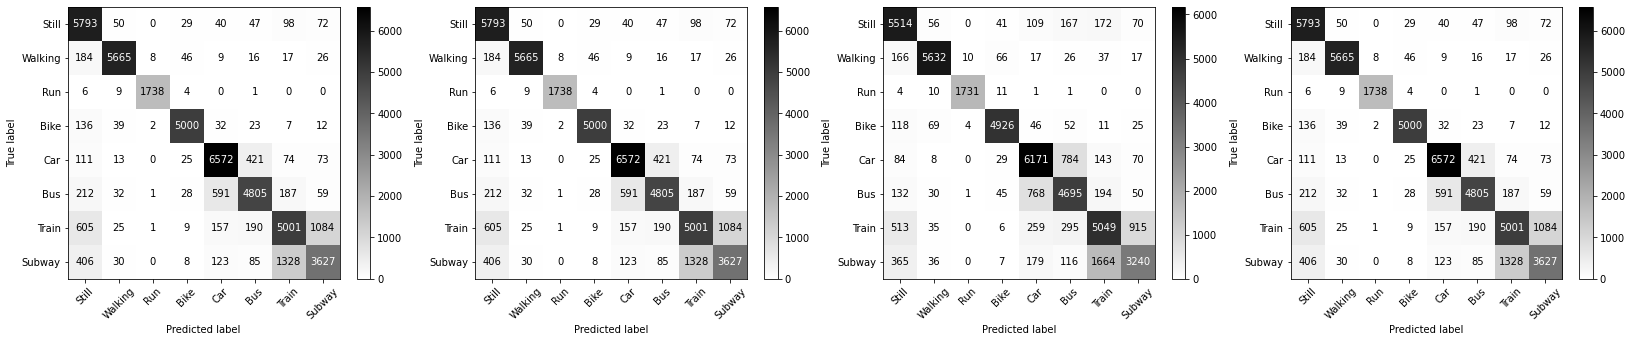

In [59]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

np.set_printoptions(precision=1)

models_to_test = [
    best_model, 
    stripped_pruned_best_model, 
    best_model_separable, 
    stripped_pruned_best_model_separable
]

f, axs = plt.subplots(1, len(models_to_test), figsize=(7 * len(models_to_test), 5))

y_test = []
for _, y_batch in validation_dataset:
    for y in y_batch:
        y_test.append(y)

for ax, model in zip(axs, models_to_test):
    y_pred_ohe = model.predict(validation_dataset)
    y_pred = [np.argmax(y) for y in y_pred_ohe]
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    conf_mat_disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=LABEL_ORDER[1:]
    )
    conf_mat_disp.plot(cmap=plt.cm.binary, ax=ax, xticks_rotation=45, values_format='')

plt.savefig('../images/shl/optimization-results.pdf', dpi=1200, bbox_inches='tight')

In [60]:
from google.colab.files import download

download('../images/shl/optimization-results.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>